In this tutorial we will build rules for fully actuated grippers

In [1]:
import numpy as np
import pychrono as chrono

from rostok.block_builder_api.block_blueprints import (PrimitiveBodyBlueprint,
                                                       RevolveJointBlueprint,
                                                       TransformBlueprint)
from rostok.block_builder_api.block_parameters import JointInputType
from rostok.block_builder_api.easy_body_shapes import Box
from rostok.block_builder_chrono.blocks_utils import FrameTransform
from rostok.graph_grammar import rule_vocabulary
from rostok.graph_grammar.node import ROOT
from rostok.graph_grammar.node_vocabulary import NodeVocabulary
from rostok.utils.dataset_materials.material_dataclass_manipulating import (
    DefaultChronoMaterialNSC, DefaultChronoMaterialSMC)

At first we create auxiliary functions.

In [2]:
def get_density_box(mass: float, box: Box):
    volume = box.height_z * box.length_y * box.width_x
    return mass / volume

def rotation_x(alpha):
    quat_X_ang_alpha = chrono.Q_from_AngX(np.deg2rad(alpha))
    return [quat_X_ang_alpha.e0, quat_X_ang_alpha.e1, quat_X_ang_alpha.e2, quat_X_ang_alpha.e3]

def rotation_y(alpha):
    quat_Y_ang_alpha = chrono.Q_from_AngY(np.deg2rad(alpha))
    return [quat_Y_ang_alpha.e0, quat_Y_ang_alpha.e1, quat_Y_ang_alpha.e2, quat_Y_ang_alpha.e3]

def rotation_z(alpha):
    quat_Z_ang_alpha = chrono.Q_from_AngZ(np.deg2rad(alpha))
    return [quat_Z_ang_alpha.e0, quat_Z_ang_alpha.e1, quat_Z_ang_alpha.e2, quat_Z_ang_alpha.e3]

Create `NodeVocabulary` and all non-terminal nodes. Here non-terminal nodes are abstract blocks as Transforms, links and joints. Also there are special nodes that represents the points that can be used to grow the graph. 

In [3]:
# Nodes
node_vocab = NodeVocabulary()
node_vocab.add_node(ROOT)
node_vocab.create_node(label="F") # base node for a finger
node_vocab.create_node(label="RF") # base node for a reversed finger


node_vocab.create_node(label="FG") # node that represents a point of finger grow
node_vocab.create_node(label="L") # abstract link

node_vocab.create_node(label="TP") # abstract positive transform node without particular value
node_vocab.create_node(label="TN") # abstract negative transform node without particular value
node_vocab.create_node(label="RT") # reverse of a finger

Next step is to create descriptions for all physical blocks.  
At first we create description for bodies

In [4]:
def_mat = DefaultChronoMaterialNSC()
# blueprint for the palm
super_flat = PrimitiveBodyBlueprint(
    Box(0.3, 0.01, 0.30), material=def_mat, color=[255, 0, 0])
# blueprint for the base
base = PrimitiveBodyBlueprint(Box(0.03, 0.01, 0.03),
                                material=def_mat,
                                color=[0, 120, 255],
                                density=10000)

# sets effective density for the links, the real links are considered to be extendable.
link_mass = (28 + 1.62 + 2.77) * 1e-3
length_link = [0.05, 0.06, 0.075]
# create link blueprints using mass and length parameters
link = list(
    map(
        lambda x: PrimitiveBodyBlueprint(Box(0.035, x, 0.027),
                                            material=def_mat,
                                            color=[0, 120, 255],
                                            density=get_density_box(link_mass, Box(
                                                0.035, x, 0.027))), length_link))
# the same in simpler code 
link = []
for length in length_link:
    bp = PrimitiveBodyBlueprint(Box(0.035, length, 0.027),
                                            material=def_mat,
                                            color=[0, 120, 255],
                                            density=get_density_box(link_mass, Box(
                                                0.035, length, 0.027)))
    link.append(bp)
    

And create the corresponding terminal nodes.

In [5]:
node_vocab.create_node(label="FT", is_terminal=True, block_blueprint=super_flat) # palm
node_vocab.create_node(label="B", is_terminal=True, block_blueprint=base)

node_vocab.create_node(label="L1", is_terminal=True,
                        block_blueprint=link[0])
node_vocab.create_node(label="L2", is_terminal=True,
                        block_blueprint=link[1])
node_vocab.create_node(label="L3", is_terminal=True,
                        block_blueprint=link[2])

Second set of physical descriptors are transformations

In [14]:
x_translation_values = [0.07, 0.107, 0.144]
X_TRANSLATIONS = list(
    map(lambda x: FrameTransform([x, 0, 0], [1, 0, 0, 0]), x_translation_values))

# rotation to 180 degrees around vertical axis
REVERSE_Y = FrameTransform([0, 0, 0], [0, 0, 1, 0])
REVERSE_Y_same = FrameTransform([0,0,0], rotation_y(180))

# create transform blueprints from the values
x_translation_transform = list(
    map(lambda x: TransformBlueprint(x), X_TRANSLATIONS))


reverse_transform = TransformBlueprint(REVERSE_Y)


In [15]:
REVERSE_Y

FrameTransform(position=[0, 0, 0], rotation=[0, 0, 1, 0])

In [16]:
REVERSE_Y_same

FrameTransform(position=[0, 0, 0], rotation=[6.123233995736766e-17, 0.0, 1.0, 0.0])

Create terminal nodes for transformations

In [7]:
node_vocab.create_node(label="RE", is_terminal=True,
                        block_blueprint=reverse_transform)

node_vocab.create_node(label="RT1",
                        is_terminal=True,
                        block_blueprint=x_translation_transform[0])
node_vocab.create_node(label="RT2",
                        is_terminal=True,
                        block_blueprint=x_translation_transform[1])
node_vocab.create_node(label="RT3",
                        is_terminal=True,
                        block_blueprint=x_translation_transform[2])

And finally describe the joint parameters. We don't need non-terminal nodes for joints because we only use one type of nodes.  

In [8]:
revolve = RevolveJointBlueprint(JointInputType.TORQUE,stiffness=1,damping=0.1)
revolve_base = RevolveJointBlueprint(JointInputType.TORQUE,stiffness=1)

In [9]:
node_vocab.create_node(label="J", is_terminal=True, block_blueprint=revolve)
node_vocab.create_node(label="JB", is_terminal=True, block_blueprint=revolve_base)

Now we have all required nodes and can start build rules

In [10]:
rule_vocab = rule_vocabulary.RuleVocabulary(node_vocab)
rule_vocab.create_rule("Init", ["ROOT"], ["FT", "F", "RF"], 0, 0,
                        [(0, 1), (0, 2)])

rule_vocab.create_rule("AddFinger", ["F"], ["RT", "B", "JB", "L", "FG"], 0, 0, [(0, 1), (1, 2),
                                                                                (2, 3), (3, 4)])
rule_vocab.create_rule("RemoveFinger", ["F"], [], 0, 0, [])

rule_vocab.create_rule("AddFinger_R", ["RF"], ["RE", "RT", "B", "JB", "L", "FG"], 0, 0,
                        [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)])
rule_vocab.create_rule("RemoveFinger_R", ["RF"], [], 0, 0, [])

rule_vocab.create_rule("Terminal_Radial_Translate1",
                        ["RT"], ["RT1"], 0, 0, [])
rule_vocab.create_rule("Terminal_Radial_Translate2",
                        ["RT"], ["RT2"], 0, 0, [])
rule_vocab.create_rule("Terminal_Radial_Translate3",
                        ["RT"], ["RT3"], 0, 0, [])

rule_vocab.create_rule("Phalanx", ["FG"], [
                        "J", "L", "FG"], 0, 0, [(0, 1), (1, 2)])

rule_vocab.create_rule("Terminal_Link1", ["L"], ["L1"], 0, 0, [])
rule_vocab.create_rule("Terminal_Link2", ["L"], ["L2"], 0, 0, [])
rule_vocab.create_rule("Terminal_Link3", ["L"], ["L3"], 0, 0, [])
rule_vocab.create_rule("Remove_FG", ["FG"], [], 0, 0, [])

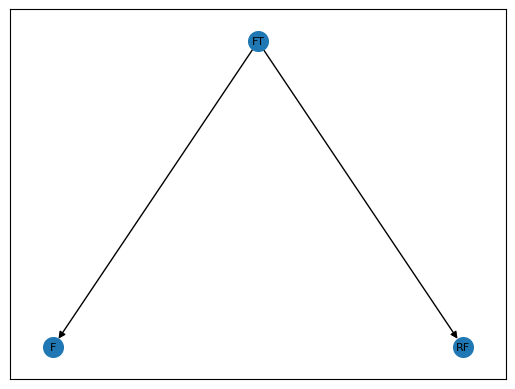

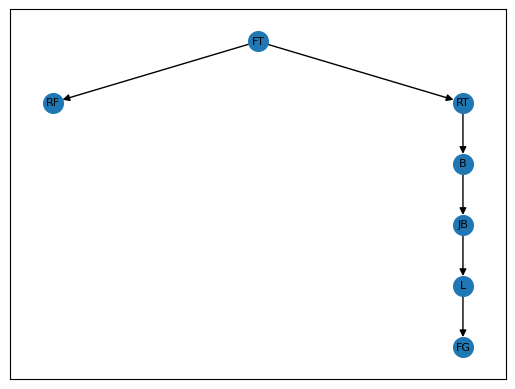

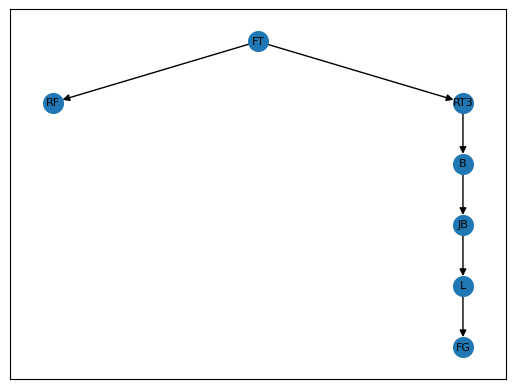

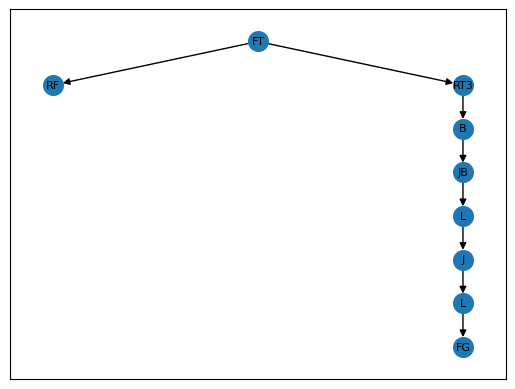

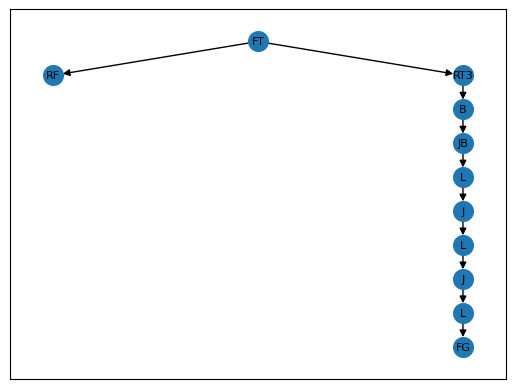

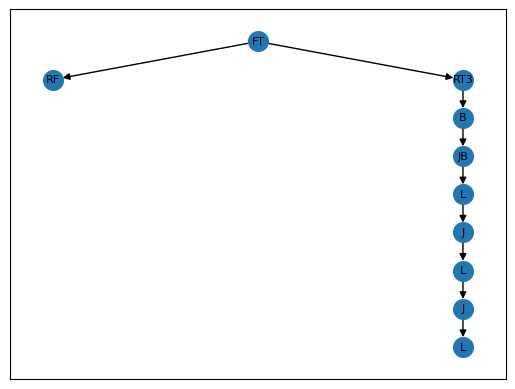

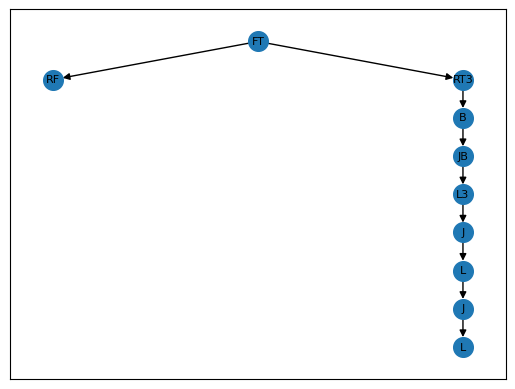

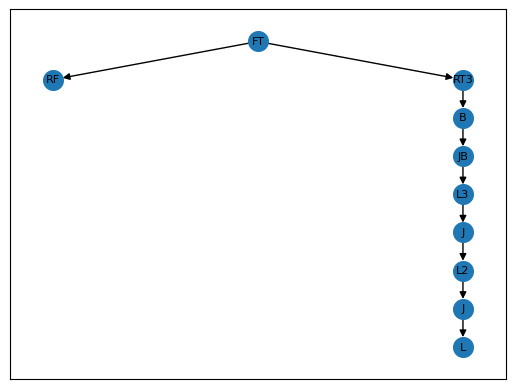

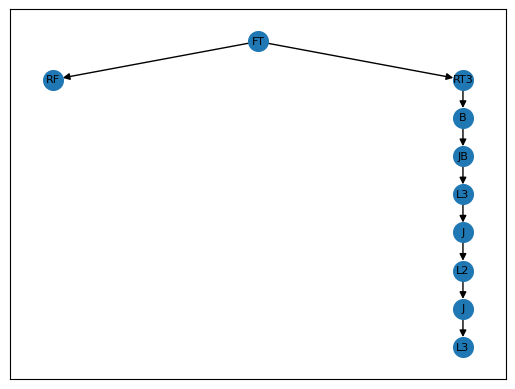

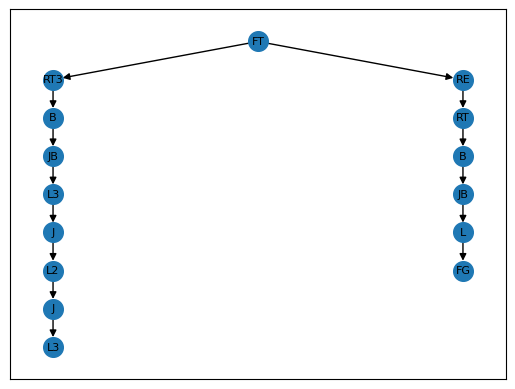

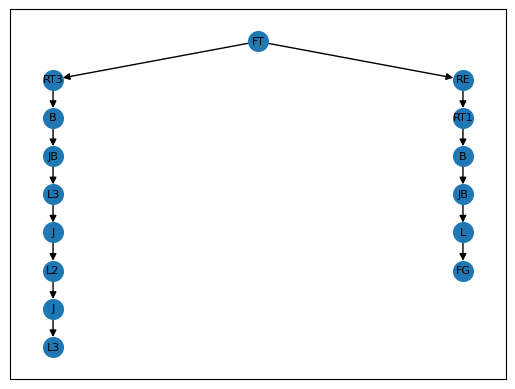

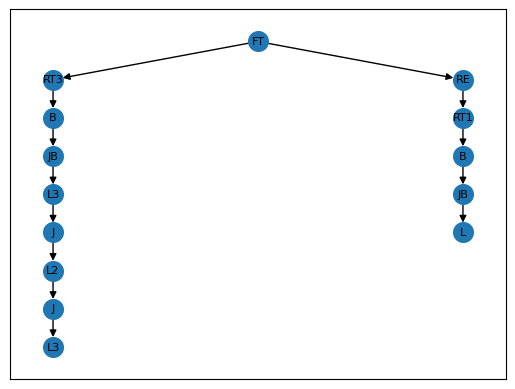

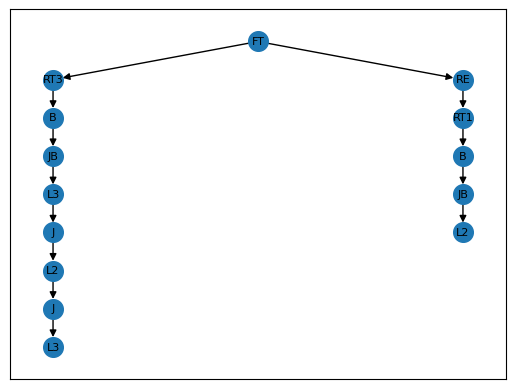

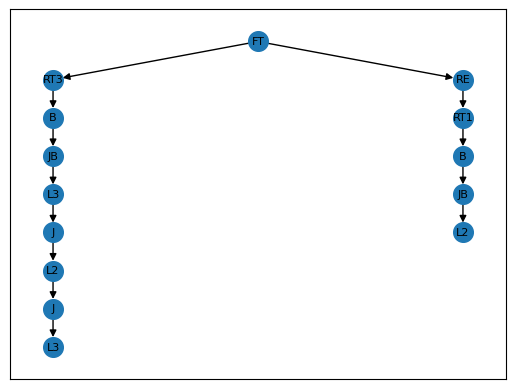

In [18]:
from rostok.graph_grammar.node import GraphGrammar
from rostok.graph_grammar.graph_utils import plot_graph
graph = GraphGrammar()
rules = ["Init",
    "AddFinger", "Terminal_Radial_Translate3",  "Phalanx", "Phalanx", "Remove_FG",
    "Terminal_Link3", "Terminal_Link2", "Terminal_Link2",
    "AddFinger_R", "Terminal_Radial_Translate1",  "Remove_FG", "Terminal_Link2",
]

for rule in rules:
    graph.apply_rule(rule_vocab.get_rule(rule))
    plot_graph(graph)


plot_graph(graph)



In [19]:

from rostok.simulation_chrono.simulation_scenario import GraspScenario
from rostok.graph_grammar.node_block_typing import get_joint_matrix_from_graph, get_joint_vector_from_graph


get_joint_matrix_from_graph(graph)


[[22], [6, 10, 13]]

In [20]:
from rostok.simulation_chrono.simulation import (ChronoSystems, EnvCreator, SingleRobotSimulation,
                                                 ChronoVisManager)
from rostok.control_chrono.controller import (ConstController, SinControllerChrono)
env_creator = EnvCreator([])
system = ChronoSystems.chrono_NSC_system(gravity_list=[0, 0, 0])
vis_manager = ChronoVisManager(delay=False)

control = {"initial_value": [2,1,1,1]}

simulation = SingleRobotSimulation(system, env_creator, vis_manager)

simulation.add_design(graph, control,
                                ConstController)
        
# setup parameters for the data store

n_steps = 10000


robot_data_dict = {}
simulation.add_robot_data_type_dict(robot_data_dict)
simulation.simulate(n_steps, 1e-3, 10, [], vis_manager)

#scenario.run_simulation(graph, control, starting_positions=[[0,0,-7,7], [0,0,-5,5], [0, 30, -60, -30, 60], [0, 30, -60, -30, 60]], vis = True, delay=True)


Irrlicht Engine version 1.8.5
Linux 6.5.0-45-generic #45~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Jul 15 16:40:02 UTC 2 x86_64
Using plain X visual
This driver is not available in Linux. Try OpenGL or Software renderer.
Irrlicht Engine version 1.8.5
Linux 6.5.0-45-generic #45~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Jul 15 16:40:02 UTC 2 x86_64
Using renderer: OpenGL 4.6
Mesa Intel(R) UHD Graphics 630 (CFL GT2): Intel
OpenGL driver version is 1.2 or better.
GLSL version: 4.6
Loaded texture: /home/be2r-lab-210134/Python/anaconda3/envs/rostok/share/chrono/data/fonts/arial80.bmp
Loaded texture: /home/be2r-lab-210134/Python/anaconda3/envs/rostok/share/chrono/data/skybox/sky_lf.jpg
Loaded texture: /home/be2r-lab-210134/Python/anaconda3/envs/rostok/share/chrono/data/skybox/sky_up.jpg
Loaded texture: /home/be2r-lab-210134/Python/anaconda3/envs/rostok/share/chrono/data/skybox/sky_dn.jpg


Cannot use default video driver - fall back to OpenGL


SimulationResult(time=9.999999999999897, time_vector=[0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.010000000000000002, 0.011000000000000003, 0.012000000000000004, 0.013000000000000005, 0.014000000000000005, 0.015000000000000006, 0.016000000000000007, 0.017000000000000008, 0.01800000000000001, 0.01900000000000001, 0.02000000000000001, 0.02100000000000001, 0.022000000000000013, 0.023000000000000013, 0.024000000000000014, 0.025000000000000015, 0.026000000000000016, 0.027000000000000017, 0.028000000000000018, 0.02900000000000002, 0.03000000000000002, 0.03100000000000002, 0.03200000000000002, 0.03300000000000002, 0.03400000000000002, 0.035000000000000024, 0.036000000000000025, 0.037000000000000026, 0.03800000000000003, 0.03900000000000003, 0.04000000000000003, 0.04100000000000003, 0.04200000000000003, 0.04300000000000003, 0.04400000000000003, 0.04500000000000003, 0.046000000000000034, 0.047000000000000035, 0.048000000000000036, 0.04900000000000004, 0.05